In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # "0,1,2,3" # "0"

In [2]:

import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [3]:
def load_img():
    noisy_arr, clean_arr = None, None
    set_num_list = ['SET01','SET02','SET03','SET04','SET05','SET06','SET07','SET08','SET09','SET10']
                
    dataset_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/test_Samsung_SNU_patches_SET01020304_divided_by_fnum_setnum.hdf5" 
    data_dict = h5py.File(dataset_path, "r")
    
    img_len = 50
    print("test wholedataset ",set_num_list)
    for set_num in set_num_list:
        set_num_idx = int(set_num[3:])
        noisy_f_num_list = ['F08','F16','F32','F64']   
        if set_num_idx >= 5 :
            dataset_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/test_Samsung_SNU_patches_SET050607080910_divided_by_fnum_setnum.hdf5"
            data_dict = h5py.File(dataset_path, "r")
            noisy_f_num_list = ['F01', 'F02', 'F04'] + noisy_f_num_list
        for f_num in noisy_f_num_list:
            if noisy_arr is None:
                noisy_arr = data_dict[set_num][f_num][:img_len]
                clean_arr = data_dict[set_num]['F64'][:img_len]
            else:
                noisy_arr = np.concatenate((noisy_arr, data_dict[set_num][f_num][:img_len]),axis=0)
                clean_arr = np.concatenate((clean_arr, data_dict[set_num]['F64'][:img_len]),axis=0)
        print(f'===Te loader {set_num} {noisy_f_num_list}===')
        print(f'{noisy_arr.shape[0]}/{clean_arr.shape[0]}  images are loaded')
    return noisy_arr, clean_arr

In [4]:
noisy_arr, clean_arr = load_img()
noisy_arr.shape

test wholedataset  ['SET01', 'SET02', 'SET03', 'SET04', 'SET05', 'SET06', 'SET07', 'SET08', 'SET09', 'SET10']
===Te loader SET01 ['F08', 'F16', 'F32', 'F64']===
200/200  images are loaded
===Te loader SET02 ['F08', 'F16', 'F32', 'F64']===
400/400  images are loaded
===Te loader SET03 ['F08', 'F16', 'F32', 'F64']===
600/600  images are loaded
===Te loader SET04 ['F08', 'F16', 'F32', 'F64']===
800/800  images are loaded
===Te loader SET05 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1150/1150  images are loaded
===Te loader SET06 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1500/1500  images are loaded
===Te loader SET07 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1850/1850  images are loaded
===Te loader SET08 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2200/2200  images are loaded
===Te loader SET09 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2550/2550  images are loaded
===Te loader SET10 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2

(2900, 256, 256)

In [5]:

name_sequence = []
for i in range(1,11):
    set_num = f"SET{i:02d}_"
    if i < 5:
        f_num_list = map(lambda x : f"{set_num}{x}",['F08', 'F16', 'F32','F64'])
    else :
        f_num_list = map(lambda x : f"{set_num}{x}",['F01', 'F02', 'F04', 'F08', 'F16', 'F32','F64'])
    name_sequence += f_num_list
print(name_sequence)
def map_image_name_to_index(set_num : str, f_num : str):
    name_to_index = {name : [i*50,(i+1)*50] for i, name in enumerate(name_sequence)}
    return name_to_index[f"{set_num}_{f_num}"]

['SET01_F08', 'SET01_F16', 'SET01_F32', 'SET01_F64', 'SET02_F08', 'SET02_F16', 'SET02_F32', 'SET02_F64', 'SET03_F08', 'SET03_F16', 'SET03_F32', 'SET03_F64', 'SET04_F08', 'SET04_F16', 'SET04_F32', 'SET04_F64', 'SET05_F01', 'SET05_F02', 'SET05_F04', 'SET05_F08', 'SET05_F16', 'SET05_F32', 'SET05_F64', 'SET06_F01', 'SET06_F02', 'SET06_F04', 'SET06_F08', 'SET06_F16', 'SET06_F32', 'SET06_F64', 'SET07_F01', 'SET07_F02', 'SET07_F04', 'SET07_F08', 'SET07_F16', 'SET07_F32', 'SET07_F64', 'SET08_F01', 'SET08_F02', 'SET08_F04', 'SET08_F08', 'SET08_F16', 'SET08_F32', 'SET08_F64', 'SET09_F01', 'SET09_F02', 'SET09_F04', 'SET09_F08', 'SET09_F16', 'SET09_F32', 'SET09_F64', 'SET10_F01', 'SET10_F02', 'SET10_F04', 'SET10_F08', 'SET10_F16', 'SET10_F32', 'SET10_F64']


In [6]:

args = get_args()
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [8]:
import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],filter_keyword = ['with_SET01020304','median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = []
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*MSE_Affine*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list
target_fbi_weight = get_fbi_weight() 

F# F01
F# F02
../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F# F04
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F# F08
../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F# F16
../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F# F32
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F# F64
../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F01 F02
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F01 F04
../wei

In [9]:
target_fbi_weight = get_fbi_weight(['F08','F32']) 

F08 F32
../weights/230414_find_lambda_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_256.w
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w


In [10]:
import math
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
def get_PSNR(X, X_hat):

    mse = np.mean((X-X_hat)**2)
    test_PSNR = 10 * math.log10(1/mse)
    
    return test_PSNR

def get_SSIM(X, X_hat):
    
    ch_axis = 0
    #test_SSIM = measure.compare_ssim(np.transpose(X, (1,2,0)), np.transpose(X_hat, (1,2,0)), data_range=X.max() - X.min(), multichannel=multichannel)
    test_SSIM = structural_similarity(X, X_hat, data_range=1.0, channel_axis=ch_axis)
    return test_SSIM

In [11]:
def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("_x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    
    return target_x,target_y, dataset_version

../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
[800, 850] [1100, 1150] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


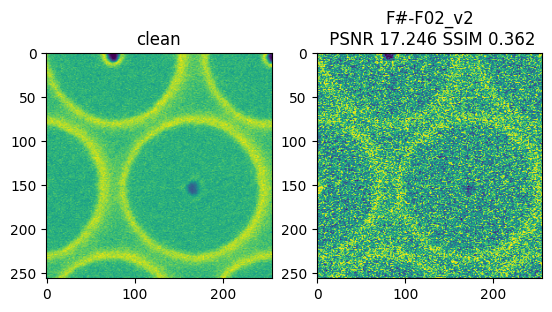

Denoising SET : SET05, f_num : F01 End
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


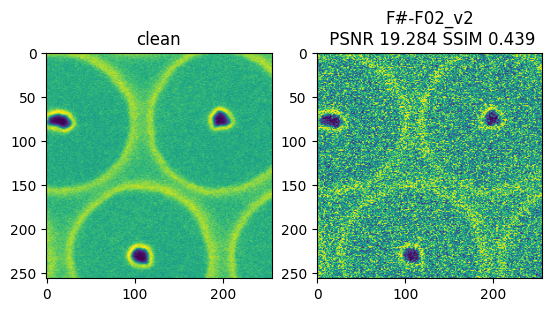

Denoising SET : SET06, f_num : F01 End
[1500, 1550] [1800, 1850] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


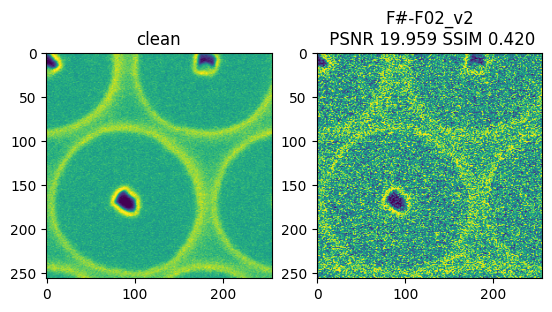

Denoising SET : SET07, f_num : F01 End
[1850, 1900] [2150, 2200] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


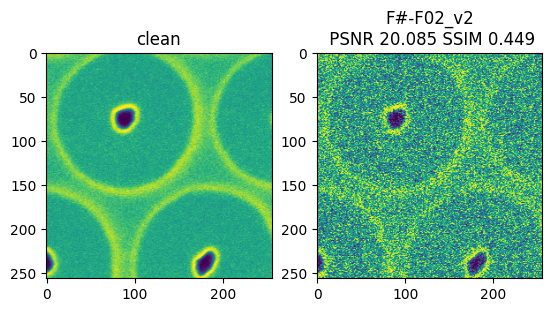

Denoising SET : SET08, f_num : F01 End
[2200, 2250] [2500, 2550] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


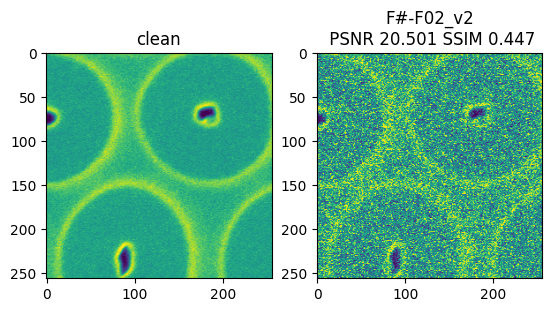

Denoising SET : SET09, f_num : F01 End
[2550, 2600] [2850, 2900] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


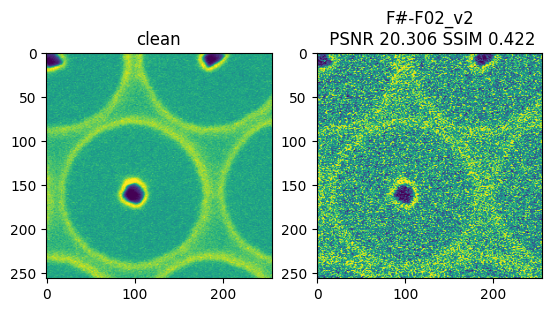

Denoising SET : SET10, f_num : F01 End
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
[800, 850] [1100, 1150] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


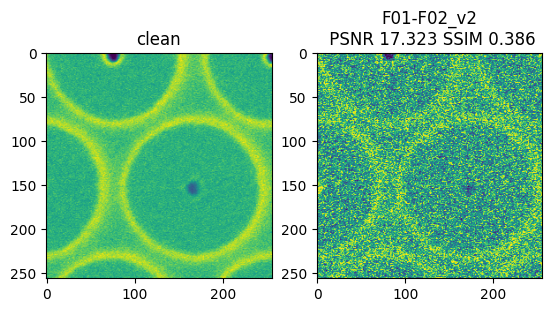

Denoising SET : SET05, f_num : F01 End
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


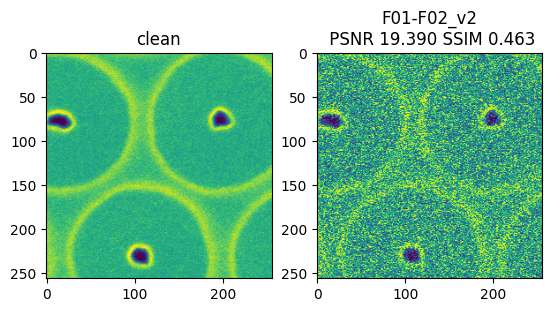

Denoising SET : SET06, f_num : F01 End
[1500, 1550] [1800, 1850] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


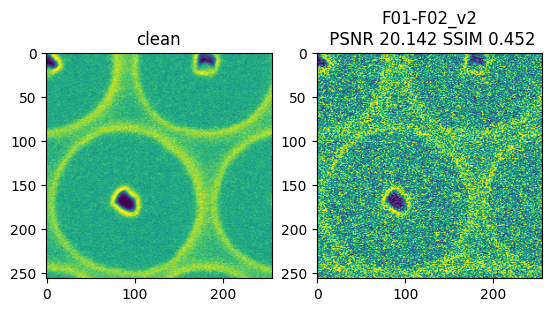

Denoising SET : SET07, f_num : F01 End
[1850, 1900] [2150, 2200] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


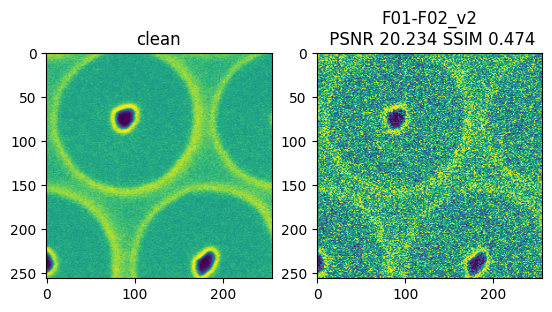

Denoising SET : SET08, f_num : F01 End
[2200, 2250] [2500, 2550] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


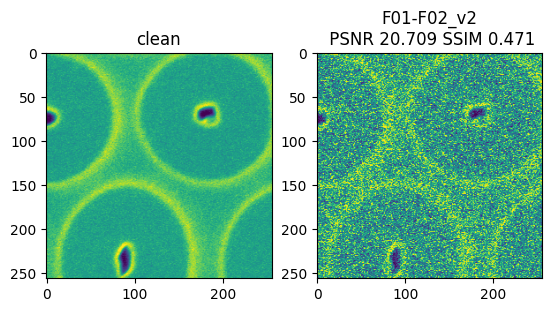

Denoising SET : SET09, f_num : F01 End
[2550, 2600] [2850, 2900] (50, 256, 256) (50, 256, 256)
0 (256, 256) (256, 256)


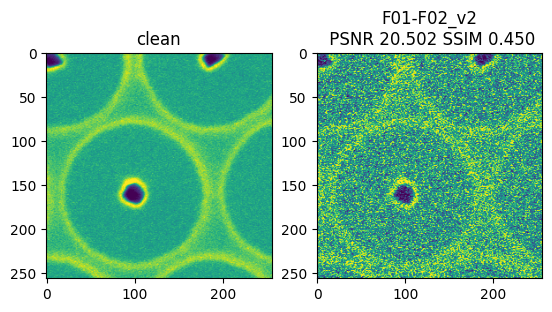

Denoising SET : SET10, f_num : F01 End


In [13]:

debug = True
metric = {}
for fbi_weight_dir in target_fbi_weight:

    target_x,target_y, dataset_version = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    key = f"{target_x}-{target_y}_{dataset_version}"
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    denoised_img_dict = {}
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
    if f_num in ['F08','F16','F32','F64']:
        set_num_list = ['SET01','SET02','SET03','SET04','SET05','SET06','SET07','SET08','SET09','SET10']
    else :
        set_num_list = ['SET05','SET06','SET07','SET08','SET09','SET10']
    for set_num in set_num_list:
        # print(set_num,f_num)
        metric[key] = {'PSNR':[],'SSIM':[],'before_PSNR':[],'before_SSIM':[]}
        index = map_image_name_to_index(set_num,f_num)
        noisy_images = noisy_arr[index[0]:index[1]]
        clean_index = map_image_name_to_index(set_num,'F64')
        clean_images = noisy_arr[clean_index[0]:clean_index[1]]
        print(set_num,f_num,index, clean_index,clean_images.shape,noisy_images.shape)
        for idx in range(50):
            noisy_img,clean_img = noisy_images[idx],clean_images[idx]
            print(idx,noisy_img.shape, clean_img.shape)
            
            img = np.expand_dims(noisy_img,0)
            img = np.expand_dims(img,0)
            
            denoised_img = model.eval(img)[0][0]
            before_psnr, before_ssim = get_PSNR(clean_img,noisy_img),get_SSIM(clean_img,noisy_img)
            psnr,ssim = get_PSNR(clean_img,denoised_img),get_SSIM(clean_img,denoised_img)
            metric[key]['PSNR'].append(psnr)
            metric[key]['SSIM'].append(ssim)
            metric[key]['before_PSNR'].append(before_psnr)
            metric[key]['before_SSIM'].append(before_ssim)
            if debug is True:
                plt.subplot(121)
                plt.title("clean")
                plt.imshow(clean_img)
                
                plt.subplot(122)
                plt.title(f"{key}\n PSNR {psnr:.3f} SSIM {ssim:.3f}")
                plt.imshow(noisy_img)
                plt.pause(0.01)
                break
        print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            
        gc.collect()
    # np.save(f"./intermediate_result/{folder_name}_denoised_img_dict.npy",denoised_img_dict)
# np.save("PSNR/SSIM_metric.npy",metric)
